In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from utils.matrix_builder import create_expanded_feature_matrix, create_feature_matrix

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load Database
csv_hour_file = '../data/ta_metrics/final_price_ta_metrics.csv'
df = pd.read_csv(csv_hour_file, parse_dates=['Datetime'])

def regression_training(df, sliding_window, lag_price_window, DEBUG):
    """
    Train a regression model using a sliding window approach.
    
    Parameters:
    - df: DataFrame containing the dataset with features and target variable.
    - sliding_window: Number of rows to use for training in each sliding window.
    - lag_price_window: Number of previous days to use as features.
    
    Returns:
    - prediction_df: DataFrame containing predictions and actual values.
    """
    if DEBUG:
        print("Debug mode is ON. Detailed output will be printed.")

    # Validate input parameters
    if sliding_window <= lag_price_window:
        raise ValueError("Sliding window must be greater than to the price feature window.")

    training_sliding_window = sliding_window + 1  # +1 to include the next row as the test set

    # Calculate number of sliding window models to train in the dataset
    num_sliding_windows = len(df) - training_sliding_window
    if DEBUG:
        # Training for sliding windows and price feature window
        print(f"Training sliding window size: {training_sliding_window}, Price feature window size: {lag_price_window}")
        print(f"Number of rows in the dataset: {len(df)}")

    print(f"Number of models to train: {num_sliding_windows}")

    # Initialize lists to store predictions, actuals, and timestamps
    predictions_list = []
    actuals_list = []
    timestamps_list = []

    model = LinearRegression()  # Using Linear Regression as a baseline model

    for i in range(num_sliding_windows):
        if DEBUG:
            print(f"Processing sliding window {i + 1}/{num_sliding_windows}...")

        # Ensure we do not exceed the DataFrame length
        if i + training_sliding_window >= len(df):
            break  # Avoid index out of bounds
        
        sliding_window_set = df.iloc[i : i + training_sliding_window]

        if DEBUG:
            print(f"Sliding window should have {training_sliding_window} rows, got {len(sliding_window_set)} rows.")
            print(f"Sliding window set:\n{sliding_window_set}")
        
        # Create feature matrix and target variable for training
        X_train, y_train = create_expanded_feature_matrix(sliding_window_set, lag_price_window)
        if DEBUG:
            print(f"Feature matrix shape: {X_train.shape}, Target variable shape: {y_train.shape}")
            print(f"Feature matrix:\n{X_train.head()}")
            print(f"Target variable:\n{y_train.head()}")

        # Split for training and prediction
        X_train_fit = X_train.iloc[:-1]
        y_train_fit = y_train.iloc[:-1]

        X_to_predict = X_train.iloc[-1:]
        y_to_predict = y_train.iloc[-1]

        if DEBUG:
            print(f"Training features shape: {X_train_fit.shape}, Training target shape: {y_train_fit.shape}")
            print(f"Features to predict shape: {X_to_predict.shape}, Target to predict: {y_to_predict}")

        # Scale features for better convergence
        scaler = StandardScaler()
        X_train_fit_scaled = scaler.fit_transform(X_train_fit)
        X_to_predict_scaled = scaler.transform(X_to_predict)

        model.fit(X_train_fit_scaled, y_train_fit)
        y_predicted = model.predict(X_to_predict_scaled)
        
        # Add a lower bounds to set extreme negative predictions to 0, assuming prices cannot be negative
        if y_predicted[0] < 0:
            y_predicted[0] = 0

        # Store results
        predictions_list.append(y_predicted[0])
        actuals_list.append(y_to_predict)
        if 'Datetime' in sliding_window_set.columns:
            timestamps_list.append(sliding_window_set.iloc[-1]['Datetime'])
        else:
            timestamps_list.append(i + training_sliding_window - 1)

    # Create final prediction DataFrame
    prediction_df = pd.DataFrame({
        'Timestamp': timestamps_list,
        'Predicted': predictions_list,
        'Actual': actuals_list
    })


    return prediction_df



def regression_training_gt(df, sliding_window, lag_price_window, DEBUG):
    """
    Train a regression model using a sliding window approach.
    
    Parameters:
    - df: DataFrame containing the dataset with features and target variable.
    - sliding_window: Number of rows to use for training in each sliding window.
    - lag_price_window: Number of previous days to use as features.
    
    Returns:
    - prediction_df: DataFrame containing predictions and actual values.
    """
    if DEBUG:
        print("Debug mode is ON. Detailed output will be printed.")

    # Validate input parameters
    if sliding_window <= lag_price_window:
        raise ValueError("Sliding window must be greater than to the price feature window.")

    training_sliding_window = sliding_window + 1  # +1 to include the next row as the test set

    # Calculate number of sliding window models to train in the dataset
    num_sliding_windows = len(df) - training_sliding_window
    if DEBUG:
        # Training for sliding windows and price feature window
        print(f"Training sliding window size: {training_sliding_window}, Price feature window size: {lag_price_window}")
        print(f"Number of rows in the dataset: {len(df)}")

    print(f"Number of models to train: {num_sliding_windows}")

    # Initialize lists to store predictions, actuals, and timestamps
    predictions_list = []
    actuals_list = []
    timestamps_list = []

    model = LinearRegression()  # Using Linear Regression as a baseline model

    for i in range(num_sliding_windows):
        if DEBUG:
            print(f"Processing sliding window {i + 1}/{num_sliding_windows}...")

        # Ensure we do not exceed the DataFrame length
        if i + training_sliding_window >= len(df):
            break  # Avoid index out of bounds
        
        sliding_window_set = df.iloc[i : i + training_sliding_window]

        if DEBUG:
            print(f"Sliding window should have {training_sliding_window} rows, got {len(sliding_window_set)} rows.")
            print(f"Sliding window set:\n{sliding_window_set}")
        
        # Create feature matrix and target variable for training
        X_train, y_train = create_feature_matrix(sliding_window_set, lag_price_window)
        if DEBUG:
            print(f"Feature matrix shape: {X_train.shape}, Target variable shape: {y_train.shape}")
            print(f"Feature matrix:\n{X_train.head()}")
            print(f"Target variable:\n{y_train.head()}")

        # Split for training and prediction
        X_train_fit = X_train.iloc[:-1]
        y_train_fit = y_train.iloc[:-1]

        X_to_predict = X_train.iloc[-1:]
        y_to_predict = y_train.iloc[-1]

        if DEBUG:
            print(f"Training features shape: {X_train_fit.shape}, Training target shape: {y_train_fit.shape}")
            print(f"Features to predict shape: {X_to_predict.shape}, Target to predict: {y_to_predict}")

        model.fit(X_train_fit, y_train_fit)
        y_predicted = model.predict(X_to_predict)
        
        # Add a lower bounds to set extreme negative predictions to 0, assuming prices cannot be negative
        if y_predicted[0] < 0:
            y_predicted[0] = 0

        # Store results
        predictions_list.append(y_predicted[0])
        actuals_list.append(y_to_predict)
        if 'Datetime' in sliding_window_set.columns:
            timestamps_list.append(sliding_window_set.iloc[-1]['Datetime'])
        else:
            timestamps_list.append(i + training_sliding_window - 1)

    # Create final prediction DataFrame
    prediction_df = pd.DataFrame({
        'Timestamp': timestamps_list,
        'Predicted': predictions_list,
        'Actual': actuals_list
    })


    return prediction_df

Original code: Prints parameters as it goes

In [2]:
# Debug parameter
DEBUG = False

# Define the Sliding Windows for the runs
sliding_windows = [7, 10, 15, 30, 90]  # of days to train on (matrix rows)
lag_price_windows = [1, 2, 4, 6]  # of previous days to use as features (matrix columns)
# lag_price_window must be less than sliding_window
percentiles = [99, 95, 85, 75]

for sliding_window in sliding_windows:
    for lag_price_window in lag_price_windows:
        print(f"\nRunning regression training with sliding window: {sliding_window}, price feature window: {lag_price_window}")

        # Run the regression training
        # prediction_df = regression_training(df, sliding_window, lag_price_window, DEBUG)
        prediction_df = regression_training_gt(df, sliding_window, lag_price_window, DEBUG)
        
        # Calculate overall metrics
        actuals_list = prediction_df['Actual'].values
        predictions_list = prediction_df['Predicted'].values
        timestamps_list = prediction_df['Timestamp'].values

        mse = mean_squared_error(actuals_list, predictions_list)
        mae = mean_absolute_error(actuals_list, predictions_list)
        r2 = r2_score(actuals_list, predictions_list)
        

        # Calculate prediction errors for filtering
        prediction_errors = np.abs(np.array(predictions_list) - np.array(actuals_list))

        print("\nMetrics for best predictions by error percentiles:")
        print(f"Overall predictions (100%) - Count: {len(predictions_list)}, MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

        for p in percentiles:
            # Filter by best predictions (lowest errors)
            error_threshold = np.percentile(prediction_errors, p)
            
            # Get indices of predictions with errors below threshold
            best_indices = prediction_errors <= error_threshold
            
            filtered_actuals = np.array(actuals_list)[best_indices]
            filtered_predictions = np.array(predictions_list)[best_indices]
            filtered_timestamps = np.array(timestamps_list)[best_indices]
            
            if len(filtered_actuals) > 0:
                mse_p = mean_squared_error(filtered_actuals, filtered_predictions)
                mae_p = mean_absolute_error(filtered_actuals, filtered_predictions)
                r2_p = r2_score(filtered_actuals, filtered_predictions)
                
                # Save the filtered predictions and actuals in a DataFrame
                filtered_df = pd.DataFrame({
                    'Timestamp': filtered_timestamps,
                    'Actual': filtered_actuals,
                    'Predicted': filtered_predictions,
                    'Error': np.abs(filtered_predictions - filtered_actuals)
                })
                filtered_df.to_csv(f'best_predictions_percentile_{p}.csv', index=False)
                
                print(f"Best {p}% predictions - Data Points: {len(filtered_predictions)}/{len(predictions_list)}, MSE: {mse_p:.4f}, MAE: {mae_p:.4f}, R²: {r2_p:.4f}")
            else:
                print(f"Best {p}% predictions - No data available")


Running regression training with sliding window: 7, price feature window: 1
Number of models to train: 2252

Metrics for best predictions by error percentiles:
Overall predictions (100%) - Count: 2252, MSE: 1000.9544, MAE: 19.2201, R²: 0.7063
Best 99% predictions - Data Points: 2229/2252, MSE: 775.9611, MAE: 17.9048, R²: 0.7660
Best 95% predictions - Data Points: 2139/2252, MSE: 465.9322, MAE: 14.9083, R²: 0.8452
Best 85% predictions - Data Points: 1914/2252, MSE: 207.5522, MAE: 10.6850, R²: 0.9215
Best 75% predictions - Data Points: 1689/2252, MSE: 107.6211, MAE: 8.0133, R²: 0.9514

Running regression training with sliding window: 7, price feature window: 2
Number of models to train: 2252

Metrics for best predictions by error percentiles:
Overall predictions (100%) - Count: 2252, MSE: 3952.2252, MAE: 27.6791, R²: -0.1597
Best 99% predictions - Data Points: 2229/2252, MSE: 1480.6675, MAE: 23.7429, R²: 0.5578
Best 95% predictions - Data Points: 2139/2252, MSE: 809.6453, MAE: 19.3226, 

In [3]:
# I want to filter the results to the following percentiles and calculate the MSE, MAE, and R^2 for each percentile
# I also want to save the predictions and actuals for each percentile in a separate DataFrame

# Calculate prediction errors for filtering
prediction_errors = np.abs(np.array(predictions_list) - np.array(actuals_list))

percentiles = [99, 95, 85, 75]
print("\nMetrics for best predictions by error percentiles:")

for p in percentiles:
    # Filter by best predictions (lowest errors)
    error_threshold = np.percentile(prediction_errors, p)
    
    # Get indices of predictions with errors below threshold
    best_indices = prediction_errors <= error_threshold
    
    filtered_actuals = np.array(actuals_list)[best_indices]
    filtered_predictions = np.array(predictions_list)[best_indices]
    filtered_timestamps = np.array(timestamps_list)[best_indices]
    
    if len(filtered_actuals) > 0:
        mse_p = mean_squared_error(filtered_actuals, filtered_predictions)
        mae_p = mean_absolute_error(filtered_actuals, filtered_predictions)
        r2_p = r2_score(filtered_actuals, filtered_predictions)
        
        # Save the filtered predictions and actuals in a DataFrame
        filtered_df = pd.DataFrame({
            'Timestamp': filtered_timestamps,
            'Actual': filtered_actuals,
            'Predicted': filtered_predictions,
            'Error': np.abs(filtered_predictions - filtered_actuals)
        })
        filtered_df.to_csv(f'best_predictions_percentile_{p}.csv', index=False)
        
        print(f"Best {p}% predictions - Count: {len(filtered_actuals)}, MSE: {mse_p:.4f}, MAE: {mae_p:.4f}, R²: {r2_p:.4f}")
    else:
        print(f"Best {p}% predictions - No data available")



Metrics for best predictions by error percentiles:
Best 99% predictions - Count: 2147, MSE: 554.7655, MAE: 15.7713, R²: 0.8369
Best 95% predictions - Count: 2060, MSE: 356.8353, MAE: 13.4198, R²: 0.8836
Best 85% predictions - Count: 1843, MSE: 176.4638, MAE: 9.9338, R²: 0.9335
Best 75% predictions - Count: 1627, MSE: 93.3325, MAE: 7.5212, R²: 0.9622


In [4]:
# I want to create a comprehensive table displaying the metrics for each percentile
percentile_metrics = []
for p in percentiles:
    error_threshold = np.percentile(prediction_errors, p)
    best_indices = prediction_errors <= error_threshold
    
    filtered_actuals = np.array(actuals_list)[best_indices]
    filtered_predictions = np.array(predictions_list)[best_indices]
    
    if len(filtered_actuals) > 0:
        mse_p = mean_squared_error(filtered_actuals, filtered_predictions)
        mae_p = mean_absolute_error(filtered_actuals, filtered_predictions)
        r2_p = r2_score(filtered_actuals, filtered_predictions)
        
        percentile_metrics.append({
            'Percentile': p,
            'Datapoint Count': len(filtered_actuals),
            'MSE': mse_p,
            'MAE': mae_p,
            'R²': r2_p
        })

# print the comprehensive table
percentile_metrics_df = pd.DataFrame(percentile_metrics)
print("\nComprehensive Metrics by Percentile:")
print(percentile_metrics_df)


Comprehensive Metrics by Percentile:
   Percentile  Datapoint Count         MSE        MAE        R²
0          99             2147  554.765456  15.771274  0.836861
1          95             2060  356.835267  13.419773  0.883569
2          85             1843  176.463756   9.933804  0.933514
3          75             1627   93.332462   7.521156  0.962245


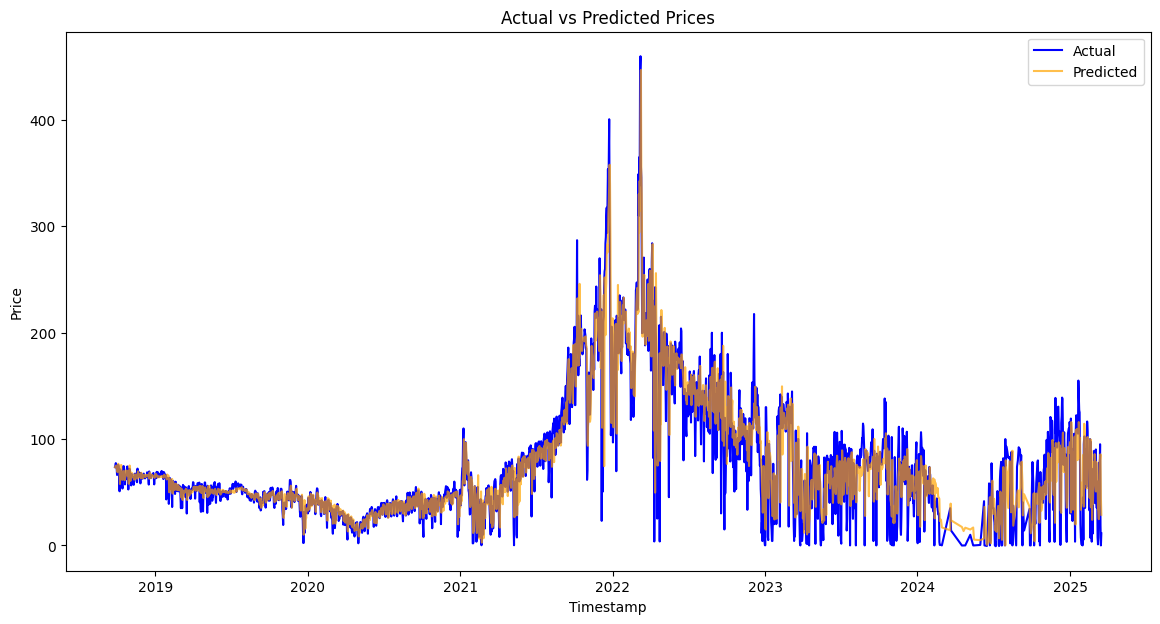

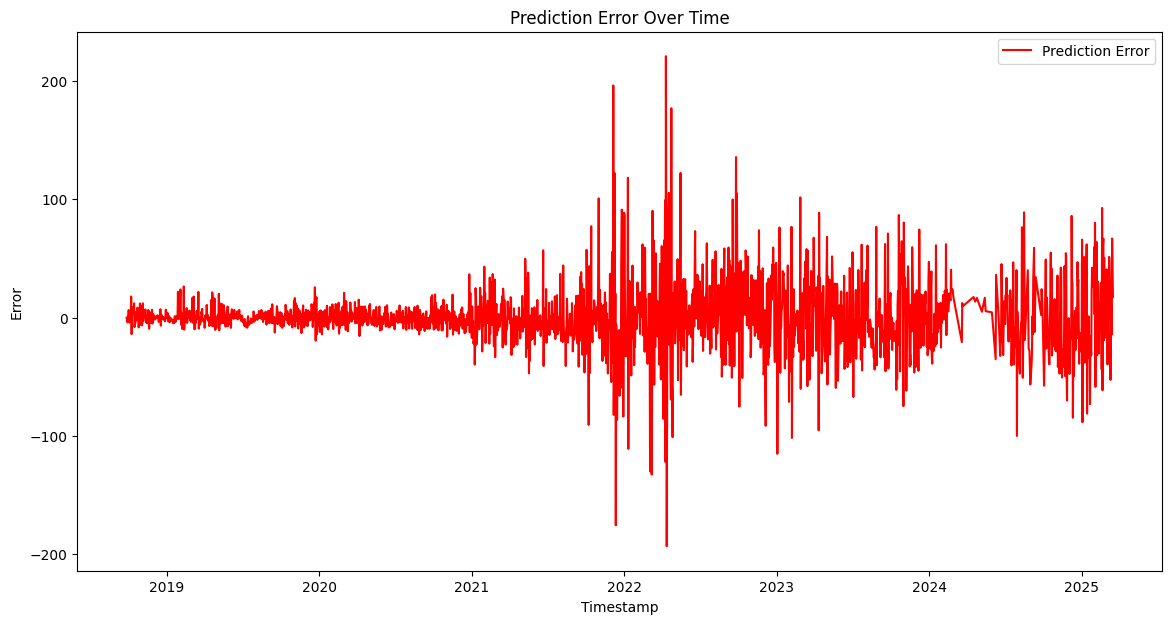

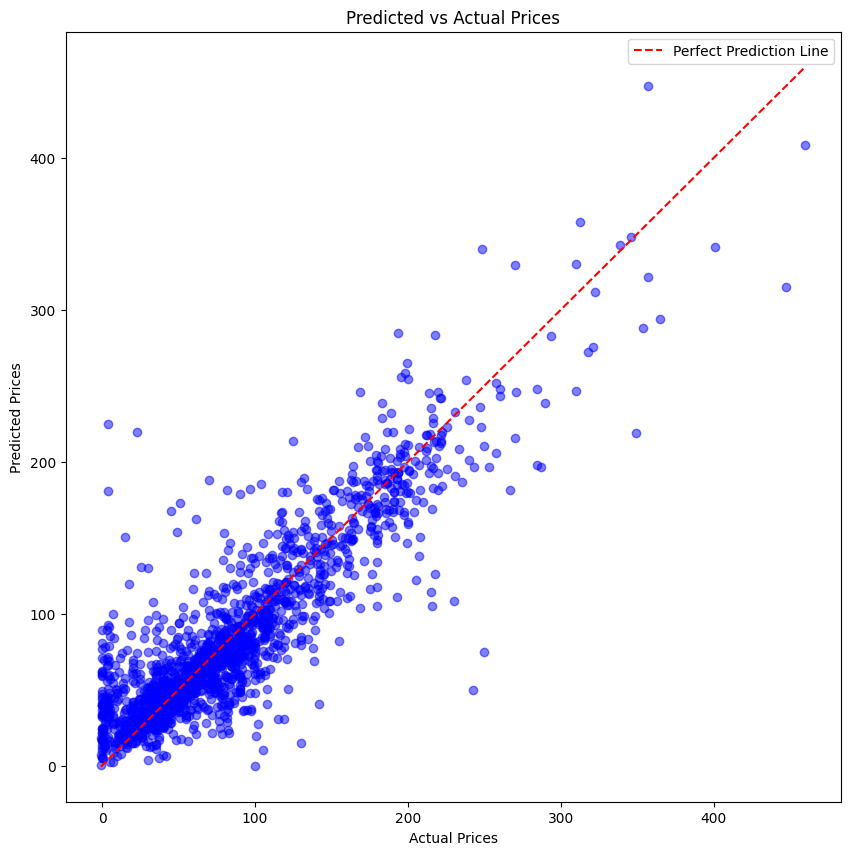

In [11]:
# Plotting the results
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(prediction_df['Timestamp'], prediction_df['Actual'], label='Actual', color='blue')
plt.plot(prediction_df['Timestamp'], prediction_df['Predicted'], label='Predicted', color='orange', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices')
# Save the figure
plt.savefig(f'regression_sw_{sliding_window}_pfw{lag_price_window}_regression_predictions.png', dpi=300)
plt.legend()

# Plot error metrics
plt.figure(figsize=(14, 7))
plt.plot(prediction_df['Timestamp'], prediction_df['Predicted'] - prediction_df['Actual'], label='Prediction Error', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Error')
plt.title('Prediction Error Over Time')
# save the figure
plt.savefig(f'regression_sw_{sliding_window}_pfw{lag_price_window}_regression_prediction_error.png', dpi=300)
plt.legend()

# Plot a scatter plot of predicted vs actual prices with the intercept line
plt.figure(figsize=(10, 10))
plt.scatter(prediction_df['Actual'], prediction_df['Predicted'], alpha=0.5, color='blue')
plt.plot([prediction_df['Actual'].min(), prediction_df['Actual'].max()],
         [prediction_df['Actual'].min(), prediction_df['Actual'].max()],
         color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual Prices')
plt.legend()


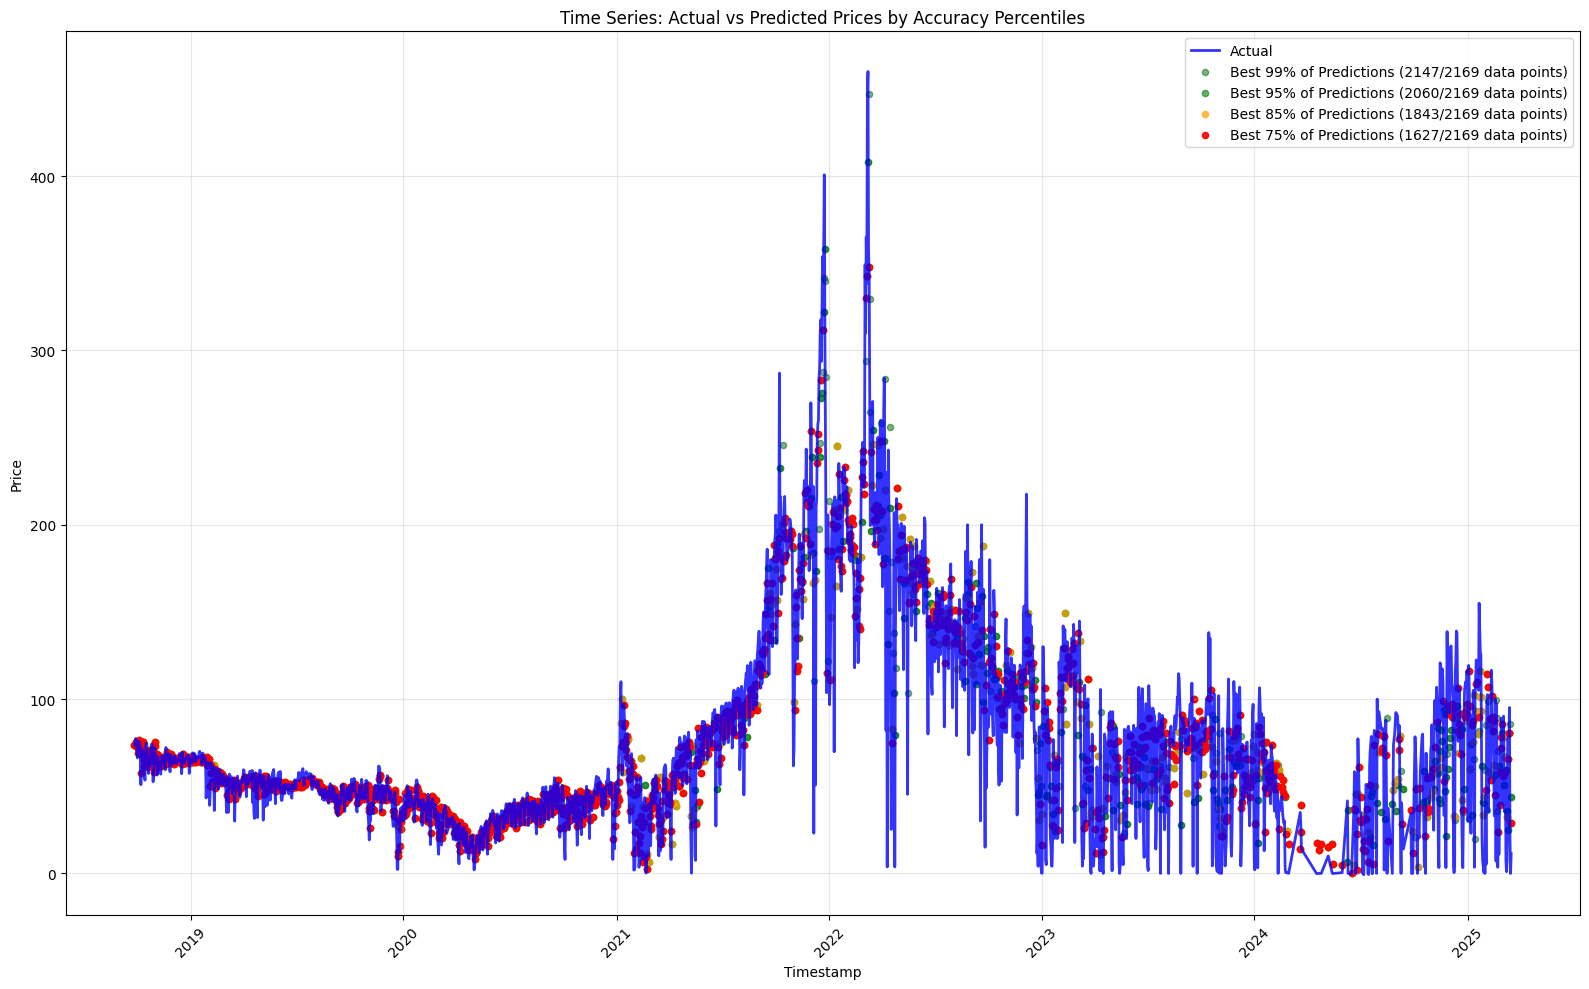

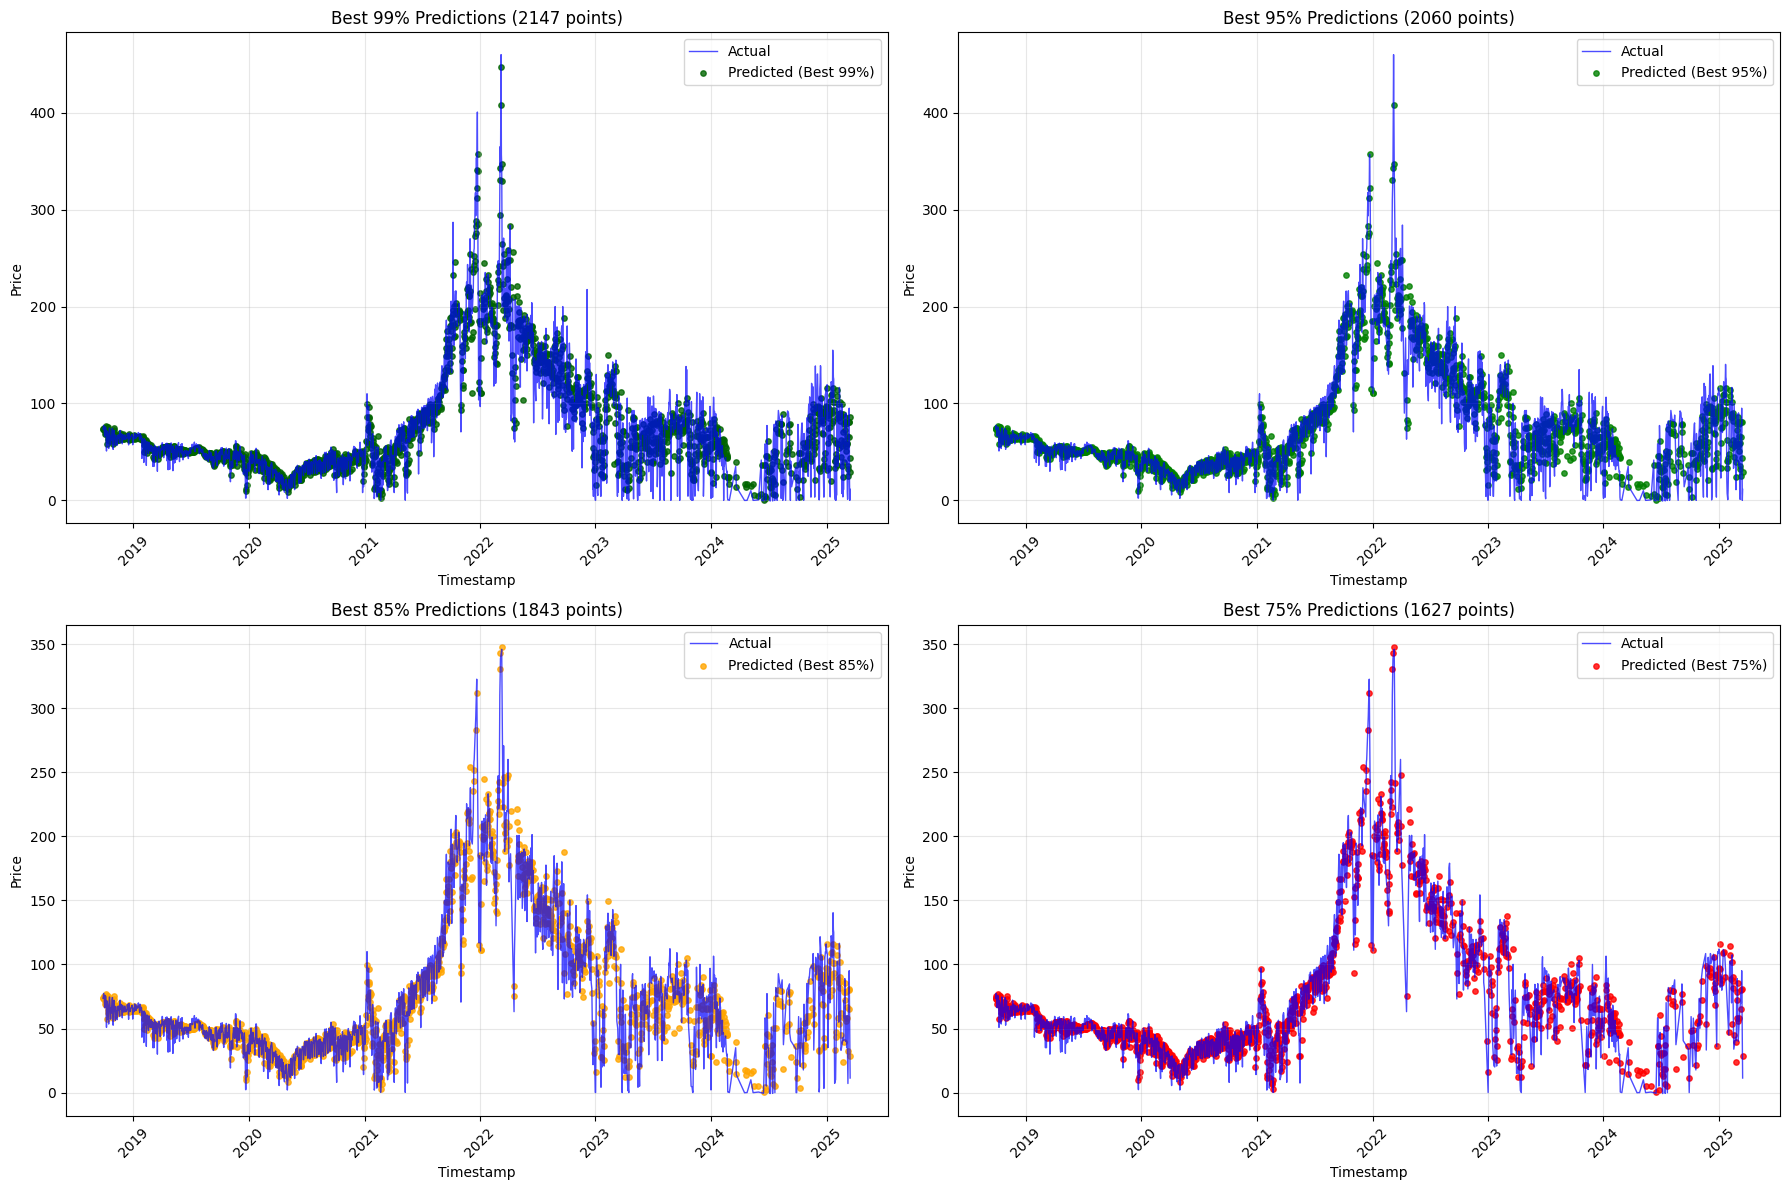

In [12]:
import matplotlib.pyplot as plt

# Time series plots for different percentile accuracies
plt.figure(figsize=(16, 10))

# Calculate prediction errors for filtering
prediction_errors = np.abs(np.array(predictions_list) - np.array(actuals_list))

percentiles = [99, 95, 85, 75]
colors = ['darkgreen', 'green', 'orange', 'red']
alphas = [0.5, 0.6, 0.7, 0.9]

# Plot actual values first
plt.plot(prediction_df['Timestamp'], prediction_df['Actual'], 
         label='Actual', color='blue', linewidth=2, alpha=0.8)

# Plot predictions for each percentile
for i, p in enumerate(percentiles):
    # Filter by best predictions (lowest errors)
    error_threshold = np.percentile(prediction_errors, p)
    best_indices = prediction_errors <= error_threshold
    
    filtered_timestamps = np.array(timestamps_list)[best_indices]
    filtered_predictions = np.array(predictions_list)[best_indices]
    
    if len(filtered_predictions) > 0:
        plt.scatter(filtered_timestamps, filtered_predictions, 
                   label=f'Best {p}% of Predictions ({len(filtered_predictions)}/{len(predictions_list)} data points)', 
                   color=colors[i], alpha=alphas[i], s=20)

plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Time Series: Actual vs Predicted Prices by Accuracy Percentiles')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Alternative: Separate subplots for each percentile
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, p in enumerate(percentiles):
    error_threshold = np.percentile(prediction_errors, p)
    best_indices = prediction_errors <= error_threshold
    
    filtered_timestamps = np.array(timestamps_list)[best_indices]
    filtered_predictions = np.array(predictions_list)[best_indices]
    filtered_actuals = np.array(actuals_list)[best_indices]
    
    if len(filtered_predictions) > 0:
        axes[i].plot(filtered_timestamps, filtered_actuals, 
                    label='Actual', color='blue', linewidth=1, alpha=0.7)
        axes[i].scatter(filtered_timestamps, filtered_predictions, 
                       label=f'Predicted (Best {p}%)', color=colors[i], alpha=0.8, s=15)
        
        axes[i].set_xlabel('Timestamp')
        axes[i].set_ylabel('Price')
        axes[i].set_title(f'Best {p}% Predictions ({len(filtered_predictions)} points)')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
# Save the figure
plt.savefig(f'regression_sw_{sliding_window}_pfw{lag_price_window}_regression_predictions_by_percentile.png', dpi=300)
plt.show()

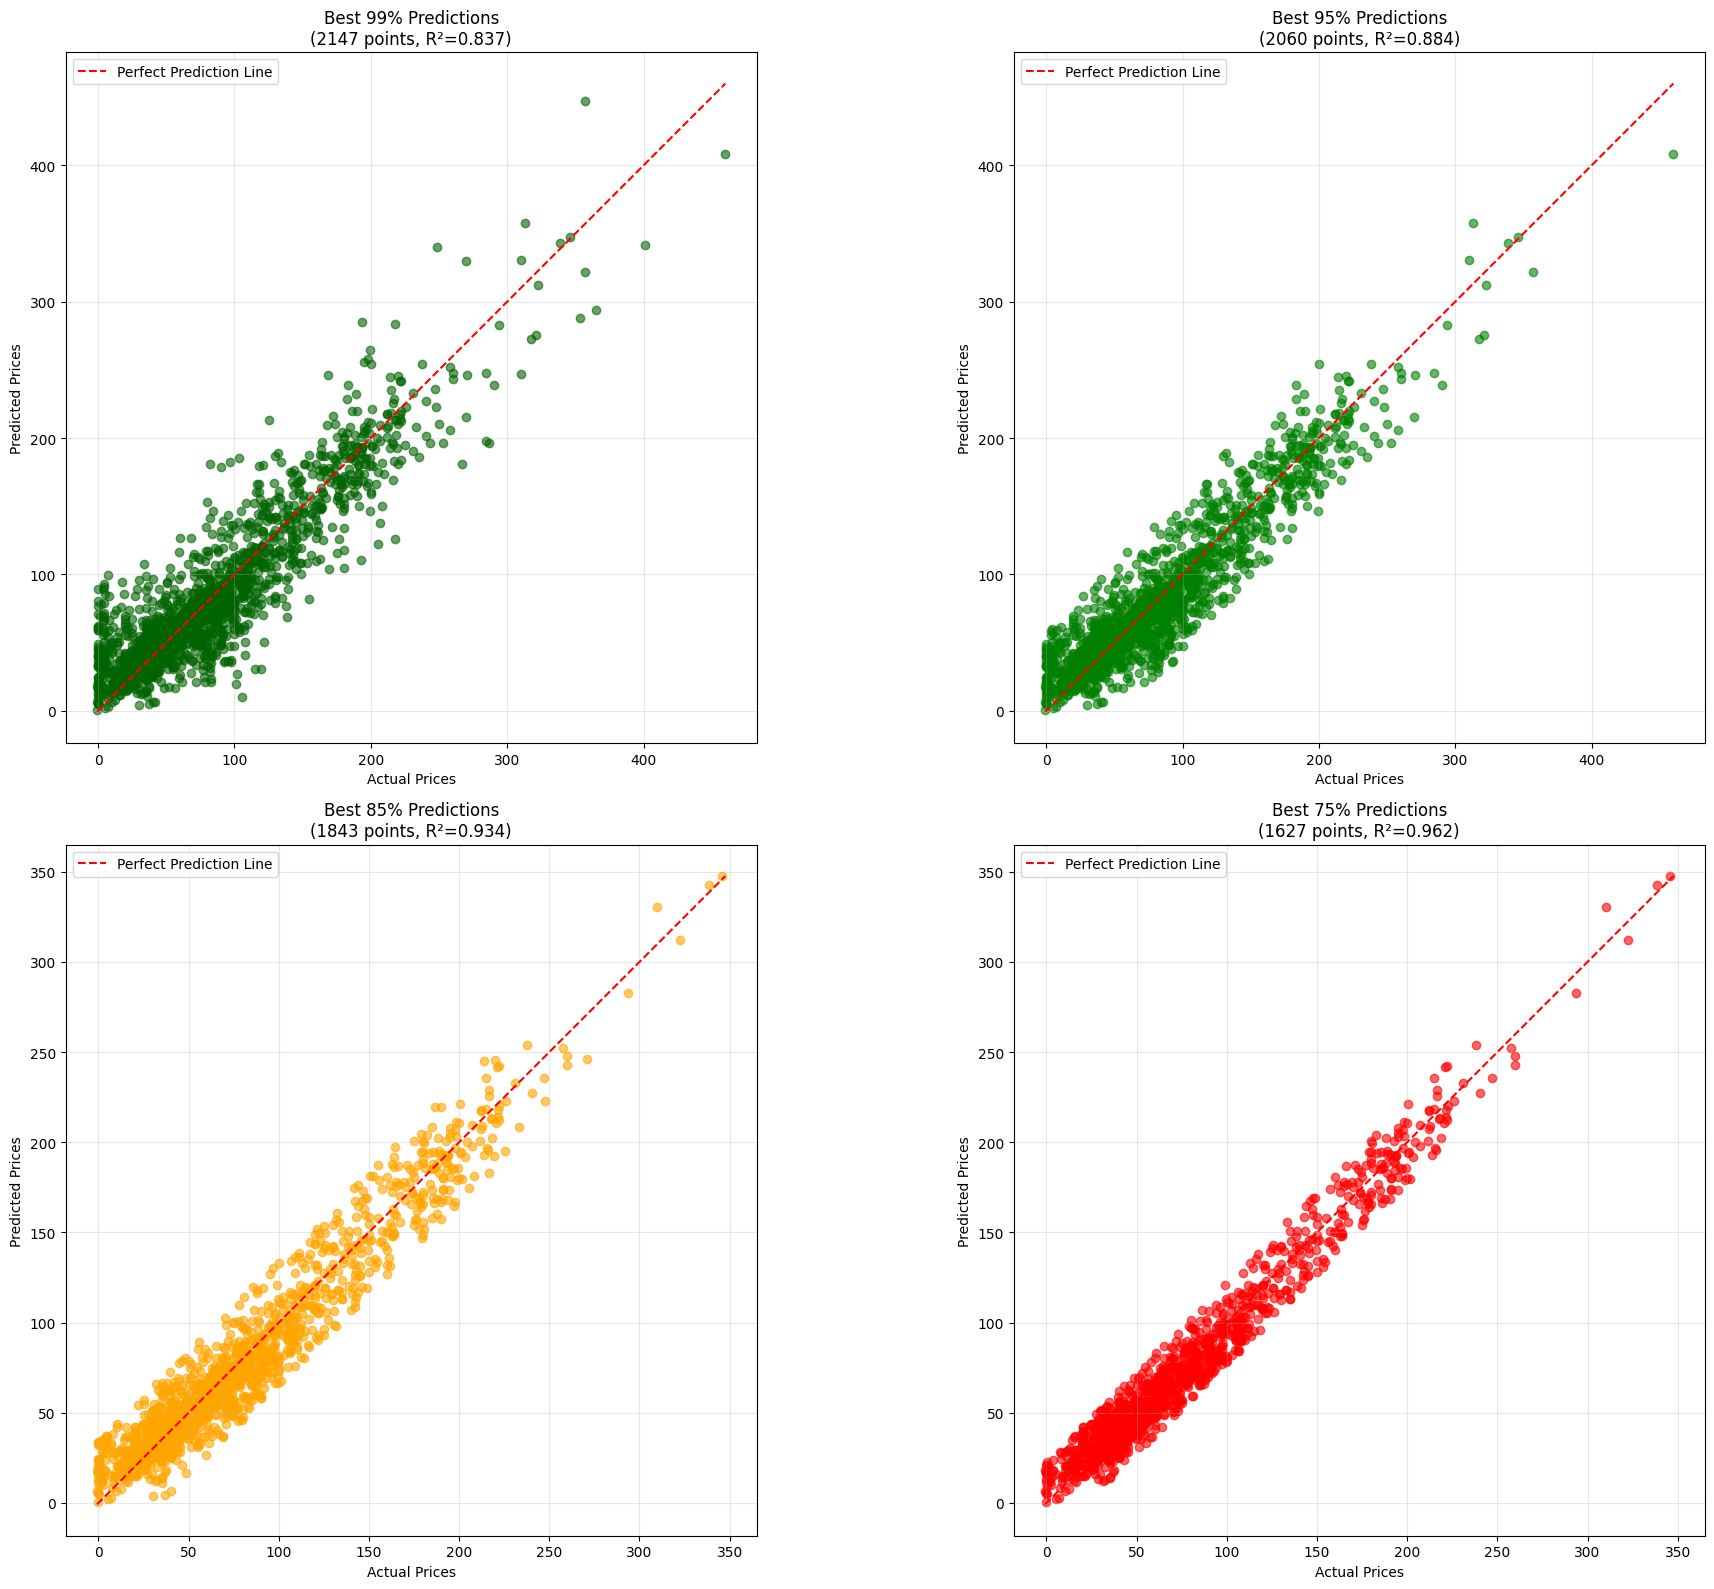

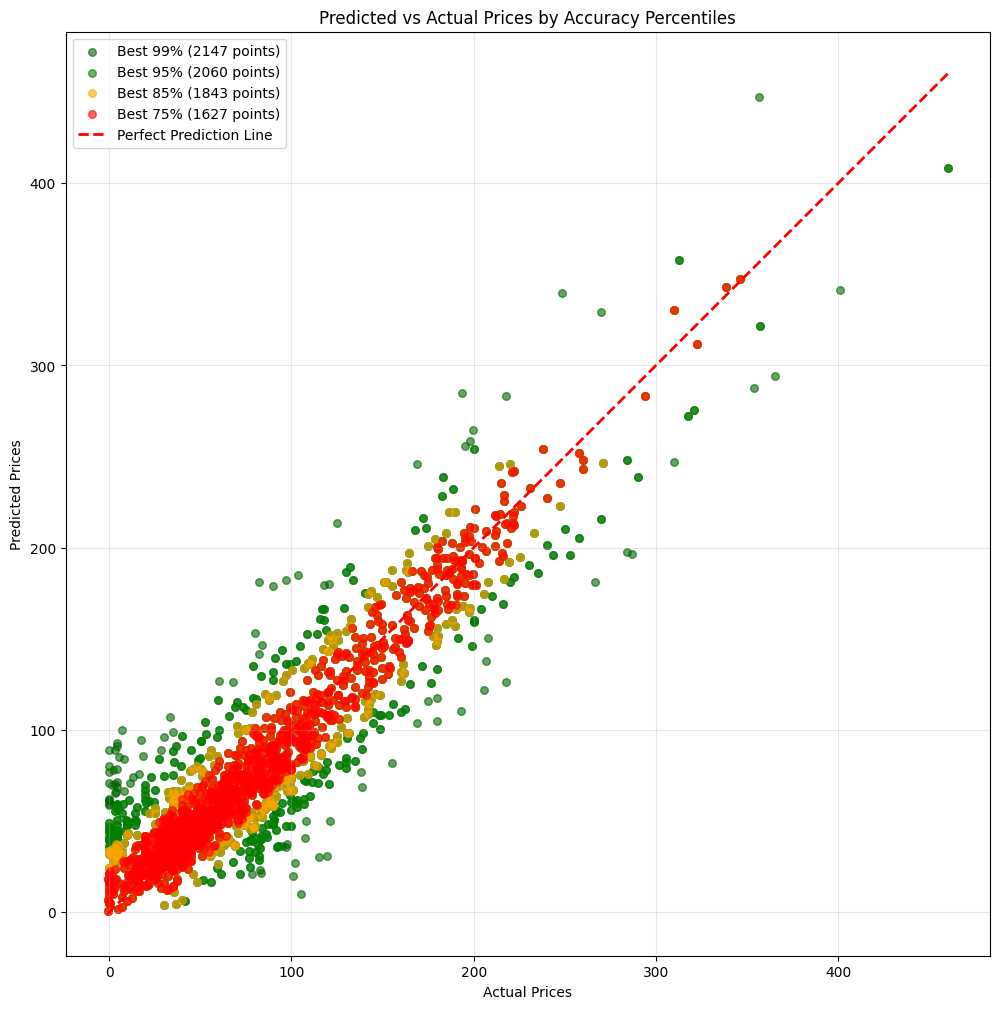

In [13]:
# Create scatter plots for each percentile group
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

# Calculate prediction errors for filtering
prediction_errors = np.abs(np.array(predictions_list) - np.array(actuals_list))

percentiles = [99, 95, 85, 75]
colors = ['darkgreen', 'green', 'orange', 'red']

for i, p in enumerate(percentiles):
    # Filter by best predictions (lowest errors)
    error_threshold = np.percentile(prediction_errors, p)
    best_indices = prediction_errors <= error_threshold
    
    filtered_actuals = np.array(actuals_list)[best_indices]
    filtered_predictions = np.array(predictions_list)[best_indices]
    
    if len(filtered_actuals) > 0:
        # Calculate metrics for this percentile
        mse_p = mean_squared_error(filtered_actuals, filtered_predictions)
        mae_p = mean_absolute_error(filtered_actuals, filtered_predictions)
        r2_p = r2_score(filtered_actuals, filtered_predictions)
        
        # Create scatter plot
        axes[i].scatter(filtered_actuals, filtered_predictions, alpha=0.6, color=colors[i])
        
        # Perfect prediction line
        min_val = min(filtered_actuals.min(), filtered_predictions.min())
        max_val = max(filtered_actuals.max(), filtered_predictions.max())
        axes[i].plot([min_val, max_val], [min_val, max_val], 
                    color='red', linestyle='--', label='Perfect Prediction Line')
        
        axes[i].set_xlabel('Actual Prices')
        axes[i].set_ylabel('Predicted Prices')
        axes[i].set_title(f'Best {p}% Predictions\n({len(filtered_actuals)} points, R²={r2_p:.3f})')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # Make axes equal for better comparison
        axes[i].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# Also create a combined scatter plot with all percentiles
plt.figure(figsize=(12, 12))

for i, p in enumerate(percentiles):
    error_threshold = np.percentile(prediction_errors, p)
    best_indices = prediction_errors <= error_threshold
    
    filtered_actuals = np.array(actuals_list)[best_indices]
    filtered_predictions = np.array(predictions_list)[best_indices]
    
    if len(filtered_actuals) > 0:
        plt.scatter(filtered_actuals, filtered_predictions, 
                   alpha=0.6, color=colors[i], 
                   label=f'Best {p}% ({len(filtered_actuals)} points)', s=30)

# Perfect prediction line
plt.plot([prediction_df['Actual'].min(), prediction_df['Actual'].max()],
         [prediction_df['Actual'].min(), prediction_df['Actual'].max()],
         color='red', linestyle='--', label='Perfect Prediction Line', linewidth=2)

plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual Prices by Accuracy Percentiles')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Extra??


Metrics for best predictions by error percentiles:
Best 90% predictions - Count: 1952, MSE: 247.7601, MAE: 11.5040, R²: 0.9117
Best 80% predictions - Count: 1735, MSE: 126.4798, MAE: 8.6076, R²: 0.9510
Best 70% predictions - Count: 1518, MSE: 69.0534, MAE: 6.5712, R²: 0.9702
Best 60% predictions - Count: 1301, MSE: 38.1414, MAE: 5.0237, R²: 0.9821


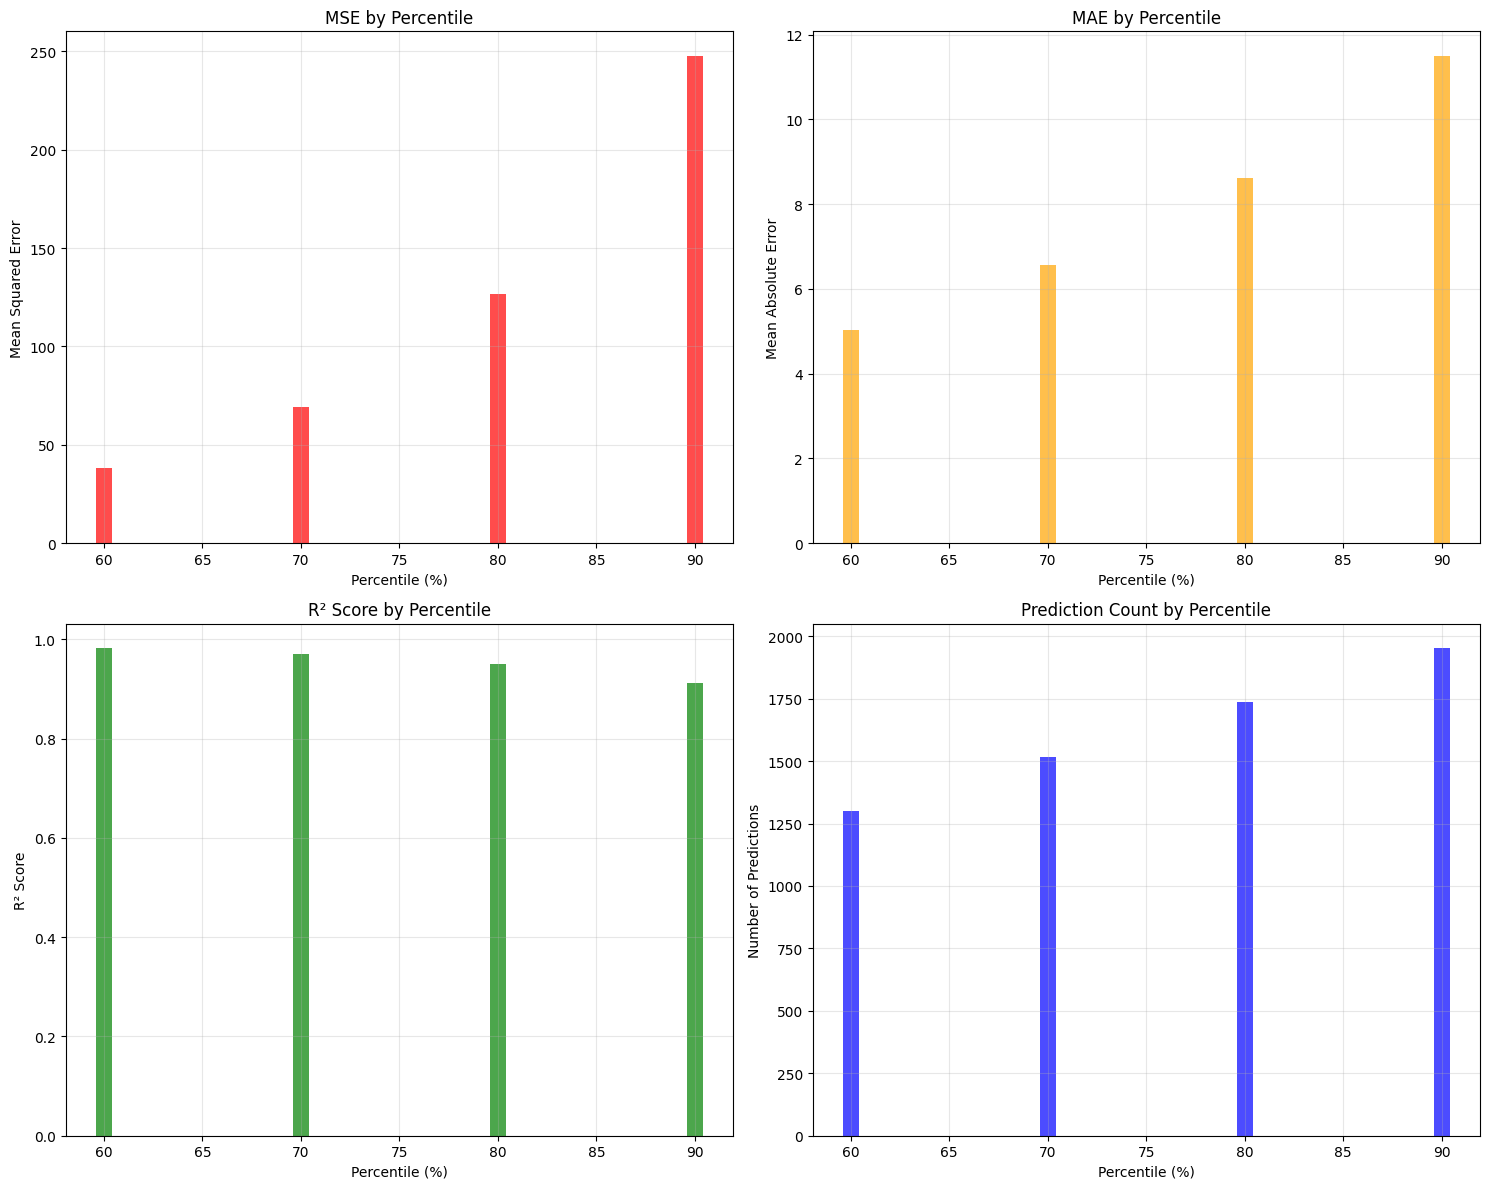

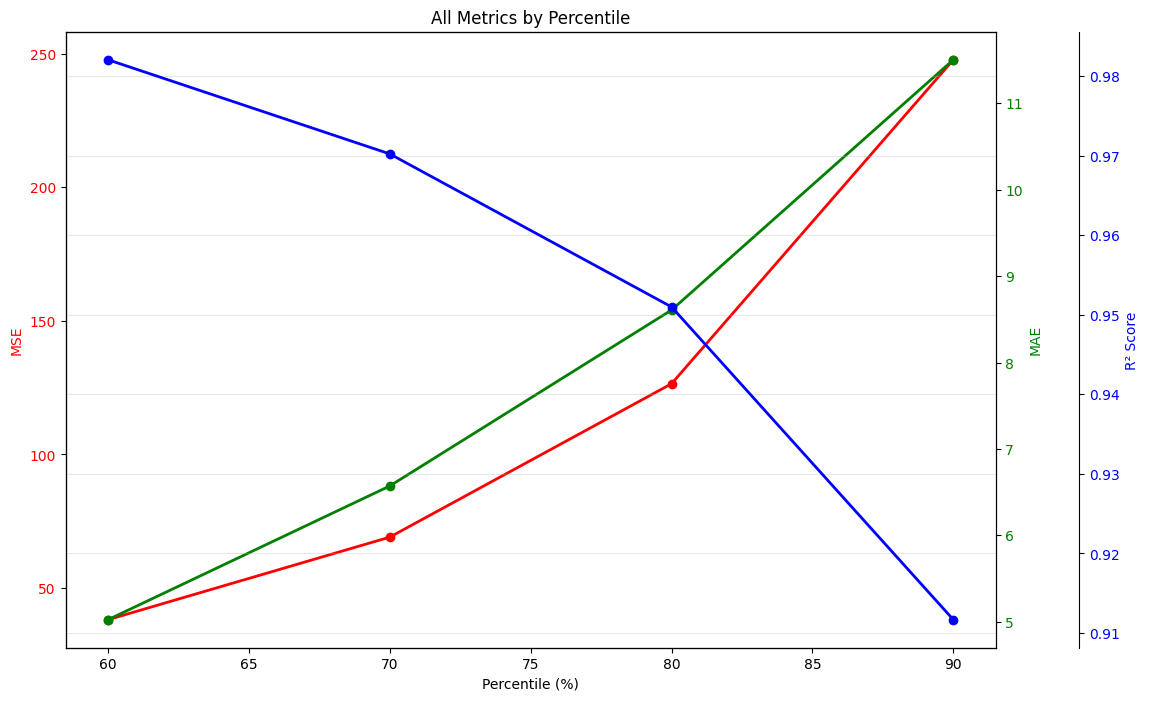

In [14]:
import matplotlib.pyplot as plt


# Collect metrics for plotting
percentile_metrics = {'Percentile': [], 'MSE': [], 'MAE': [], 'R2': [], 'Count': []}

# Calculate prediction errors for filtering
prediction_errors = np.abs(np.array(predictions_list) - np.array(actuals_list))

percentiles = [90, 80, 70, 60]
print("\nMetrics for best predictions by error percentiles:")

for p in percentiles:
    # Filter by best predictions (lowest errors)
    error_threshold = np.percentile(prediction_errors, p)
    
    # Get indices of predictions with errors below threshold
    best_indices = prediction_errors <= error_threshold
    
    filtered_actuals = np.array(actuals_list)[best_indices]
    filtered_predictions = np.array(predictions_list)[best_indices]
    filtered_timestamps = np.array(timestamps_list)[best_indices]
    
    if len(filtered_actuals) > 0:
        mse_p = mean_squared_error(filtered_actuals, filtered_predictions)
        mae_p = mean_absolute_error(filtered_actuals, filtered_predictions)
        r2_p = r2_score(filtered_actuals, filtered_predictions)
        
        # Store metrics for plotting
        percentile_metrics['Percentile'].append(p)
        percentile_metrics['MSE'].append(mse_p)
        percentile_metrics['MAE'].append(mae_p)
        percentile_metrics['R2'].append(r2_p)
        percentile_metrics['Count'].append(len(filtered_actuals))
        
        # Save the filtered predictions and actuals in a DataFrame
        filtered_df = pd.DataFrame({
            'Timestamp': filtered_timestamps,
            'Actual': filtered_actuals,
            'Predicted': filtered_predictions,
            'Error': np.abs(filtered_predictions - filtered_actuals)
        })
        filtered_df.to_csv(f'best_predictions_percentile_{p}.csv', index=False)
        
        print(f"Best {p}% predictions - Count: {len(filtered_actuals)}, MSE: {mse_p:.4f}, MAE: {mae_p:.4f}, R²: {r2_p:.4f}")
    else:
        print(f"Best {p}% predictions - No data available")

# Create joint plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: MSE by Percentile
ax1.bar(percentile_metrics['Percentile'], percentile_metrics['MSE'], color='red', alpha=0.7)
ax1.set_xlabel('Percentile (%)')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('MSE by Percentile')
ax1.grid(True, alpha=0.3)

# Plot 2: MAE by Percentile
ax2.bar(percentile_metrics['Percentile'], percentile_metrics['MAE'], color='orange', alpha=0.7)
ax2.set_xlabel('Percentile (%)')
ax2.set_ylabel('Mean Absolute Error')
ax2.set_title('MAE by Percentile')
ax2.grid(True, alpha=0.3)

# Plot 3: R² by Percentile
ax3.bar(percentile_metrics['Percentile'], percentile_metrics['R2'], color='green', alpha=0.7)
ax3.set_xlabel('Percentile (%)')
ax3.set_ylabel('R² Score')
ax3.set_title('R² Score by Percentile')
ax3.grid(True, alpha=0.3)

# Plot 4: Count by Percentile
ax4.bar(percentile_metrics['Percentile'], percentile_metrics['Count'], color='blue', alpha=0.7)
ax4.set_xlabel('Percentile (%)')
ax4.set_ylabel('Number of Predictions')
ax4.set_title('Prediction Count by Percentile')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional combined line plot
plt.figure(figsize=(12, 8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax3 = ax1.twinx()

# Offset the third axis
ax3.spines['right'].set_position(('outward', 60))

line1 = ax1.plot(percentile_metrics['Percentile'], percentile_metrics['MSE'], 'ro-', label='MSE', linewidth=2)
line2 = ax2.plot(percentile_metrics['Percentile'], percentile_metrics['MAE'], 'go-', label='MAE', linewidth=2)
line3 = ax3.plot(percentile_metrics['Percentile'], percentile_metrics['R2'], 'bo-', label='R²', linewidth=2)

ax1.set_xlabel('Percentile (%)')
ax1.set_ylabel('MSE', color='red')
ax2.set_ylabel('MAE', color='green')
ax3.set_ylabel('R² Score', color='blue')

ax1.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='y', labelcolor='green')
ax3.tick_params(axis='y', labelcolor='blue')

plt.title('All Metrics by Percentile')
plt.grid(True, alpha=0.3)
plt.show()